# Imports and settings

In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib
import os
import requests
import re
import unicodedata
import fasttext
import math
from sklearn.cross_decomposition import PLSRegression
from datetime import timedelta
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from binance.um_futures import UMFutures
from sklearn.ensemble import IsolationForest
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from datetime import timedelta, time
import pytz
from math import exp
from sentence_transformers import SentenceTransformer

In [3]:
from xgboost import XGBClassifier, XGBRegressor

## Settings, maps and constans

In [4]:
RND_STATE = 37
# CLEAN_TOKEN_NAMES_STR = True
WORTHY_QUANTILE_THRESHOLD = 0.9925

# TOKEN_NAME_MAX_LEN = 35
# TOKEN_SYMBOL_MAX_LEN = 25
# TOKENIZED_VAR_PRESERVE = 0.9
TOKENIZED_NEME_DIM = 128
TOKENIZED_SYMBOL_DIM = 64
FEATURE_IMPORTANCE_THRESHOLD = 0.25
SELECTION_SAVE_DIR = "models"
os.makedirs(SELECTION_SAVE_DIR, exist_ok=True)
NAME_INDICES_PATH = os.path.join(SELECTION_SAVE_DIR, "important_name_indices.joblib")
SYMBOL_INDICES_PATH = os.path.join(SELECTION_SAVE_DIR, "important_symbol_indices.joblib")
REFIT_REDUCE_MODELS = False

SCALE_DATASET = False
# DISPLAY_PCA = True

dex_mapping = {
    "raydium": 6,
    "fluxbeam": 5,
    "meteora": 4,
    "pumpswap": 3,
    "orca": 2,
    "pumpfunamm": 1
}
sessions = {
    # Ameryka Północna
    'NYSE': {'start': time(9, 30), 'end': time(16, 0), 'timezone': 'America/New_York'},
    'NASDAQ': {'start': time(9, 30), 'end': time(16, 0), 'timezone': 'America/New_York'},
    # Europa
    'LSE': {'start': time(8, 0), 'end': time(16, 30), 'timezone': 'Europe/London'},
    'Xetra': {'start': time(9, 0), 'end': time(17, 30), 'timezone': 'Europe/Berlin'},
    # Azja i Pacyfik
    'TSE_Morning': {'start': time(9, 0), 'end': time(11, 30), 'timezone': 'Asia/Tokyo'},
    'TSE_Afternoon': {'start': time(12, 30), 'end': time(15, 30), 'timezone': 'Asia/Tokyo'},
    'SSE_Morning': {'start': time(9, 30), 'end': time(11, 30), 'timezone': 'Asia/Shanghai'},
    'SSE_Afternoon': {'start': time(13, 0), 'end': time(15, 0), 'timezone': 'Asia/Shanghai'},
    'BSE': {'start': time(9, 15), 'end': time(15, 30), 'timezone': 'Asia/Kolkata'},
    'ASX': {'start': time(10, 0), 'end': time(16, 0), 'timezone': 'Australia/Sydney'},
    'HOSE_Morning': {'start': time(9, 15), 'end': time(11, 30), 'timezone': 'Asia/Ho_Chi_Minh'},
    'HOSE_Afternoon': {'start': time(13, 0), 'end': time(14, 30), 'timezone': 'Asia/Ho_Chi_Minh'},
    'PSE_Morning': {'start': time(9, 30), 'end': time(12, 0), 'timezone': 'Asia/Manila'},
    'PSE_Afternoon': {'start': time(13, 0), 'end': time(14, 45), 'timezone': 'Asia/Manila'},
    'PSX': {'start': time(9, 32), 'end': time(15, 30), 'timezone': 'Asia/Karachi'},
    'SET_Morning': {'start': time(10, 0), 'end': time(12, 30), 'timezone': 'Asia/Bangkok'},
    'SET_Afternoon': {'start': time(14, 0), 'end': time(16, 30), 'timezone': 'Asia/Bangkok'},
    'IDX': {'start': time(9, 0), 'end': time(15, 50), 'timezone': 'Asia/Jakarta'},
    # Bliski Wschód i Afryka
    'DFM': {'start': time(10, 0), 'end': time(15, 0), 'timezone': 'Asia/Dubai'},
    'NSE_Nigeria': {'start': time(10, 0), 'end': time(14, 20), 'timezone': 'Africa/Lagos'},
    'BIST_Morning': {'start': time(9, 30), 'end': time(12, 30), 'timezone': 'Europe/Istanbul'},
    'BIST_Afternoon': {'start': time(14, 0), 'end': time(17, 30), 'timezone': 'Europe/Istanbul'},
    'NSE_Kenya': {'start': time(9, 0), 'end': time(15, 0), 'timezone': 'Africa/Nairobi'},
    # Ameryka Południowa
    'B3': {'start': time(10, 0), 'end': time(16, 55), 'timezone': 'America/Sao_Paulo'},
    'BCBA': {'start': time(11, 0), 'end': time(17, 0), 'timezone': 'America/Argentina/Buenos_Aires'},
    'BVC': {'start': time(9, 30), 'end': time(15, 55), 'timezone': 'America/Bogota'},
}

## Custom functions

In [5]:
def compute_session_feature(row, session_info):
    # Get the timestamp from the 'pairCreatedAt' column and ensure it's tz-aware.
    timestamp = row['pairCreatedAt']
    if timestamp.tzinfo is None:
        timestamp = timestamp.tz_localize("UTC")
    
    # Convert timestamp to the session's local timezone.
    tz = pytz.timezone(session_info['timezone'])
    timestamp_local = timestamp.astimezone(tz)
    
    session_start_time = session_info['start']
    session_end_time = session_info['end']
    
    # Create datetime objects for the session's start and end for the current day.
    start_datetime = timestamp_local.replace(hour=session_start_time.hour,
                                               minute=session_start_time.minute,
                                               second=session_start_time.second,
                                               microsecond=0)
    end_datetime = timestamp_local.replace(hour=session_end_time.hour,
                                             minute=session_end_time.minute,
                                             second=session_end_time.second,
                                             microsecond=0)
    
    # Case 1: Timestamp is before session open (pre-session break)
    if timestamp_local < start_datetime:
        # Previous session's closing is assumed to be on the previous day.
        prev_day = timestamp_local - timedelta(days=1)
        # Build the datetime for previous session's close on the previous day.
        prev_close = start_datetime.replace(year=prev_day.year,
                                              month=prev_day.month,
                                              day=prev_day.day,
                                              hour=session_end_time.hour,
                                              minute=session_end_time.minute,
                                              second=session_end_time.second,
                                              microsecond=0)
        # Total duration of the break (in seconds) between previous close and today's open.
        off_period = (start_datetime - prev_close).total_seconds()
        elapsed = (timestamp_local - prev_close).total_seconds()
        # Normalize the elapsed time in the break period.
        x = elapsed / off_period
        # Use a non-linear sinusoidal transformation: 0 at boundaries, -1 at the middle.
        feature = -math.sin(math.pi * x)
        return feature

    # Case 2: Timestamp is after session close (post-session break)
    elif timestamp_local > end_datetime:
        # Next session's open is assumed to be on the following day.
        next_day = timestamp_local + timedelta(days=1)
        next_open = start_datetime.replace(year=next_day.year,
                                           month=next_day.month,
                                           day=next_day.day,
                                           hour=session_start_time.hour,
                                           minute=session_start_time.minute,
                                           second=session_start_time.second,
                                           microsecond=0)
        off_period = (next_open - end_datetime).total_seconds()
        elapsed = (timestamp_local - end_datetime).total_seconds()
        x = elapsed / off_period
        feature = -math.sin(math.pi * x)
        return feature

    # Case 3: Timestamp is within the session time.
    else:
        session_period = (end_datetime - start_datetime).total_seconds()
        elapsed = (timestamp_local - start_datetime).total_seconds()
        x = elapsed / session_period
        # Sinusoidal transformation: 0 at open (x=0) and close (x=1), +1 at the middle (x=0.5).
        feature = math.sin(math.pi * x)
        return feature

def clean_string(s):
    if isinstance(s, str):
        # Usuń niewidoczne znaki kontrolne
        s = "".join(c for c in s if unicodedata.category(c)[0] != "C")
        # Zastąp nadmiarowe białe znaki pojedynczą spacją
        s = re.sub(r"\s+", " ", s)
        # Usuń białe znaki z początku i końca
        return s.strip()
    else:
        raise ValueError(f'{s} is not a string.')

# Helper function: select feature indices based on cumulative importance threshold
def select_features_cumulative(importances, threshold):
    # Sort feature indices in descending order of importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    # Compute cumulative sum of the sorted importances
    cumulative_importance = np.cumsum(sorted_importances)
    # Determine the minimal number of features required to reach the threshold
    num_features = np.searchsorted(cumulative_importance, threshold, side='right') + 1
    selected_indices = sorted_indices[:num_features]
    # Optionally, sort the selected indices to maintain a consistent order
    return np.sort(selected_indices)

# Reading dataset

In [6]:
df = pd.read_csv("data/tokens_raw_reclassified.csv")
df.describe()

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,BTCUSDT_ATR_1d,BTCUSDT_RSI_1d,BTCUSDT_ULTOSC_1d,BTCUSDT_TSF_1d,worthy,current_priceUsd,current_txns_h24_buy,current_txns_h24_sells,current_volume_h24,current_liquidity_usd
count,6.639420e+05,6.639420e+05,663942.000000,663942.000000,663942.000000,663942.000000,663942.000000,663942.000000,663942.000000,663942.000000,...,663942.000000,663942.000000,663942.000000,663942.000000,663942.000000,6.639420e+05,663942.000000,663942.000000,6.639420e+05,6.639420e+05
mean,1.956352e+03,1.952031e+05,75.513780,45.397601,75.769887,45.515013,75.769887,45.515013,75.769887,45.515013,...,3492.318935,50.569863,51.792729,86463.591693,-0.249791,1.485291e+01,4.555493,4.113609,6.224259e+02,2.210464e+04
std,7.518328e+05,8.122669e+07,160.824856,127.588768,161.698365,128.032011,161.698365,128.032011,161.698365,128.032011,...,842.558073,11.709386,6.829167,13182.899701,0.439621,4.391858e+03,798.730459,802.753149,6.734651e+04,4.673928e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1813.653648,22.389872,31.349518,53559.864835,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,6.205000e-08,1.042000e-05,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,...,3056.787539,43.373363,47.632958,79537.668132,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,3.638000e-07,6.132500e-05,13.000000,1.000000,13.000000,1.000000,13.000000,1.000000,13.000000,1.000000,...,3461.509138,47.437239,51.605019,87632.045055,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,3.447000e-06,5.866750e-04,71.000000,25.000000,71.000000,25.000000,71.000000,25.000000,71.000000,25.000000,...,4091.276846,58.050350,56.232436,96538.721429,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
max,5.296914e+08,6.302060e+10,9835.000000,4193.000000,9835.000000,4193.000000,9835.000000,4193.000000,9835.000000,4193.000000,...,5176.083929,83.796139,74.095431,108017.973626,1.000000,1.553260e+06,449862.000000,451538.000000,2.892268e+07,3.139605e+09


In [7]:
# Simple cleaning
df.drop_duplicates(subset=["pairAddress"], inplace=True)  # or 'baseTokenAddress'
df = df[df['quoteTokenName'] == 'Wrapped SOL'] # Only Sol tokens
df.describe()

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,BTCUSDT_ATR_1d,BTCUSDT_RSI_1d,BTCUSDT_ULTOSC_1d,BTCUSDT_TSF_1d,worthy,current_priceUsd,current_txns_h24_buy,current_txns_h24_sells,current_volume_h24,current_liquidity_usd
count,4.193660e+05,4.193660e+05,419366.000000,419366.000000,419366.000000,419366.000000,419366.000000,419366.000000,419366.000000,419366.000000,...,419366.000000,419366.000000,419366.000000,419366.000000,419366.000000,4.193660e+05,419366.000000,419366.000000,4.193660e+05,4.193660e+05
mean,1.337397e+03,2.789879e+05,73.960815,44.510189,74.301539,44.669143,74.301539,44.669143,74.301539,44.669143,...,3586.486133,52.292628,52.154967,89235.393470,-0.196954,1.054138e+01,4.321411,3.831517,5.550851e+02,2.093129e+04
std,4.537845e+05,1.010814e+08,160.396775,125.193028,161.478885,125.775688,161.478885,125.775688,161.478885,125.775688,...,790.271995,12.231280,6.947760,12846.936554,0.404322,3.856383e+03,796.952803,796.785370,6.800661e+04,5.318429e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1813.653648,22.389872,31.349518,53568.579121,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,6.805000e-08,1.207000e-05,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,...,3214.097375,43.892061,47.795223,82299.180769,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,3.704000e-07,6.748000e-05,12.000000,1.000000,12.000000,1.000000,12.000000,1.000000,12.000000,1.000000,...,3562.937149,49.291558,51.819973,95083.737912,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,3.207000e-06,6.072000e-04,67.000000,23.000000,68.000000,23.000000,68.000000,23.000000,68.000000,23.000000,...,4157.112560,60.967790,56.794835,97628.589011,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
max,2.753434e+08,6.302060e+10,9835.000000,4193.000000,9835.000000,4193.000000,9835.000000,4193.000000,9835.000000,4193.000000,...,5176.083929,83.796139,74.095431,108017.973626,1.000000,1.455102e+06,449862.000000,451538.000000,2.892268e+07,3.139605e+09


# Feature engineering

## Simple features

In [8]:
# Convert 'pairCreatedAt' to datetime and compute the number of days since listing
df["pairCreatedAt"] = pd.to_datetime(df["pairCreatedAt"])
df["days_since_listing"] = (pd.Timestamp.today() - df["pairCreatedAt"]).dt.days
df["days_since_listing"].value_counts()

days_since_listing
64     7602
55     7488
54     7221
65     6665
53     6574
       ... 
341      36
32       28
76       19
77       16
245       7
Name: count, Length: 226, dtype: int64

In [9]:
df['dexId'] = df['dexId'].map(dex_mapping).astype(int)
df["liq_fdv_ratio"] = ((df["liquidity_usd"] / df["fdv"]).replace([np.inf, -np.inf], 0).fillna(0))

## Target/weight engineering

In [10]:
df['current_txns_sum'] = df["current_txns_h24_buy"] + df["current_txns_h24_sells"]
df['price_ratio'] = df['current_priceUsd']/df['priceUsd']

df["target"] = np.log1p(
    (df["current_priceUsd"] / df["priceUsd"].replace(0, np.nan)).fillna(0) *
    df['days_since_listing']
)

eps = 0.000001
avg_cur_vol = df["current_volume_h24"].mean()
avg_cur_liq = df["current_liquidity_usd"].mean()
avg_cur_txns_sum = df["current_txns_sum"].mean()
cur_vol_liq_ratio = (df["current_volume_h24"]/df["current_liquidity_usd"].replace(0, np.nan)).fillna(0)

df["weight"] = np.sqrt(
    # np.log1p(eps+(cur_vol_liq_ratio).fillna(0)) +
    np.log1p(eps+(df["current_volume_h24"] / df["volume_h24"].replace(0, np.nan)).fillna(0)) +
    # np.log1p(eps+(df["current_liquidity_usd"] / df["liquidity_usd"].replace(0, np.nan)).fillna(0)) +
    np.log1p(eps+((df["current_txns_h24_buy"] + df["current_txns_h24_sells"]) /
                (df["txns_h24_buy"] + df["txns_h24_sells"]).replace(0, np.nan)).fillna(0))
)

# low_liquidity_threshold = df["current_liquidity_usd"].mean()
# df["weight"] = np.where(df["current_liquidity_usd"] < low_liquidity_threshold,
#                        df["weight"] * (df["current_liquidity_usd"] / low_liquidity_threshold),
#                        df["weight"])

# low_volume_threshold = df["current_volume_h24"].mean()
# df["weight"] = np.where(df["current_volume_h24"] < low_liquidity_threshold,
#                        df["weight"] * (df["current_volume_h24"] / low_liquidity_threshold),
#                        df["weight"])

In [11]:
avg_cur_vol

555.0850916621757

In [12]:
avg_cur_liq

20931.293299409106

In [13]:
avg_cur_txns_sum

8.152928468211538

In [14]:
np.quantile(df["current_liquidity_usd"], [0.99, 1.])

array([6.16607450e+03, 3.13960494e+09])

In [15]:
df["current_liquidity_usd"].mean()

20931.293299409106

In [16]:
np.quantile(df["current_volume_h24"], [0.99, 1.])

array([2.17800000e+01, 2.89226842e+07])

In [17]:
df["current_volume_h24"].median()

0.0

In [18]:
df["weight"].mean()

0.011708356702073017

In [19]:
df["weight"].isna().sum()

0

In [20]:
df["target"]

0         0.000000
1         0.000000
2         0.000000
4         0.000000
5         0.000000
            ...   
647409    0.000000
647411    0.178917
647413    1.980672
647415    0.000000
647417    0.100769
Name: target, Length: 419366, dtype: float64

In [21]:
assert (df["weight"].isna().any() or df["target"].isna().any()) == False

In [22]:
df.sort_values(by="target", ascending=False).head(25)[
    [
        "pairAddress",
        "pairCreatedAt",
        "days_since_listing",
        "baseTokenName",
        "target",
        "weight",
        "current_volume_h24",
        "volume_h24",
        "current_liquidity_usd",
        "liquidity_usd",
        "current_txns_h24_buy",
        "current_txns_h24_sells",
        "txns_h24_buy",
        "txns_h24_sells",
        "current_priceUsd",
        "priceUsd",
        "fdv",
        "url",
    ]
]

,pairAddress,pairCreatedAt,days_since_listing,baseTokenName,target,weight,current_volume_h24,volume_h24,current_liquidity_usd,liquidity_usd,current_txns_h24_buy,current_txns_h24_sells,txns_h24_buy,txns_h24_sells,current_priceUsd,priceUsd,fdv,url
59430,CBfr5r5zisR29S46LT3oD9B8tL5FwiTVD6ZPaeN1zy6J,2024-12-03 20:07:57,135,Hugo,26.007784,0.531609,6.54,31.75,5.526905e+07,66.99,0.0,1.0,7,3.0,1.309800e+01,8.964000e-09,0.0,https://dexscreener.com/solana/cbfr5r5zisr29s4...
68019,G2ymABPrsqvh8jAiESGu2JgqC5Pi5bD6YjUCHWQ7oD3p,2024-12-07 21:23:05,131,8008135,21.654307,0.672019,0.57,12.07,9.169000e+01,0.01,1.0,0.0,1,1.0,4.226000e-06,2.182000e-13,0.0,https://dexscreener.com/solana/g2ymabprsqvh8ja...
137586,Ag6zKUFtiYPis1b2hn1tULuFGHeztJyz69s1nRRMaoba,2025-01-21 22:33:20,86,GOHOME,15.972232,1.619636,1080.23,2277.02,7.012250e+03,2443.18,113.0,104.0,22,4.0,2.264200e+02,2.253000e-03,0.0,https://dexscreener.com/solana/ag6zkuftiypis1b...
375047,6baPHStDeiwxxmDPNhVGtuRN2J9LJGbfRmFqkHWD8zTt,2025-03-20 18:27:22,28,Shiba Saga,15.249158,0.258257,0.01,2939.55,1.592000e+01,25970.23,1.0,1.0,28,1.0,1.216700e+03,8.123000e-03,0.0,https://dexscreener.com/solana/6baphstdeiwxxmd...
296150,BVe9zWP595CHkWKHepwtiPGx9NBUBHEcU1d1ihH2yEv2,2024-10-22 08:29:14,177,NYESO DAO,14.179554,1.594926,157.83,15.57,7.254570e+03,0.72,1.0,0.0,6,1.0,2.936000e-05,3.611000e-09,0.0,https://dexscreener.com/solana/bve9zwp595chkwk...
413687,G8mUszSUVgZDYHFMG63P4Wmys3Y2aGr6oY4exy9cLnMW,2025-04-13 13:58:24,4,MetaGPU,13.495519,0.566997,0.02,6.59,2.700000e-01,7790.23,1.0,2.0,7,1.0,3.540000e+00,1.950000e-05,0.0,https://dexscreener.com/solana/g8muszsuvgzdyhf...
236278,Dvc8gbcoam9keySeJ74UeSexJSsEviABjnxvbx5pMgVQ,2025-02-22 19:39:04,54,Doctor Odin,13.095833,2.442187,1026.15,9.31,1.346131e+04,133.09,13.0,12.0,10,0.0,1.394000e-03,1.546000e-07,0.0,https://dexscreener.com/solana/dvc8gbcoam9keys...
411575,EczDoxAgU7RYnozuLx4aEPniDjtppA6Kut33bCnPdCdu,2025-04-10 22:24:12,7,GigaTrumpPepe,12.961295,0.096310,0.00,1319.81,6.100000e-01,0.20,2.0,1.0,257,65.0,5.305000e-05,8.725000e-10,0.0,https://dexscreener.com/solana/eczdoxagu7rynoz...
55052,EiL4DDCYrEF4XcKyu6FvxK7qXE7u5MFqPrxbex5FzVz7,2024-12-02 12:23:12,136,NYANMARU COIN,12.644467,2.751922,490983.18,6565.39,9.297021e+05,18044.55,519.0,443.0,35,4.0,1.674000e-03,7.343000e-07,0.0,https://dexscreener.com/solana/eil4ddcyref4xck...
97268,3YTfX8KzLhuqBqXAunqbBizjoDdY3VHHBEDyGrf91KT2,2024-12-23 08:19:26,115,Solaxy,12.183784,0.920489,0.00,0.22,7.243255e+08,425840.00,4.0,0.0,3,0.0,2.592000e-01,1.524000e-04,0.0,https://dexscreener.com/solana/3ytfx8kzlhuqbqx...


In [23]:
non_zero_targets = df[df['target'] > 0]['target']
print(non_zero_targets.describe())

count    1.024500e+04
mean     2.069695e+00
std      1.906296e+00
min      7.817986e-21
25%      6.839480e-01
50%      1.593463e+00
75%      2.975948e+00
max      2.600778e+01
Name: target, dtype: float64


<Axes: xlabel='weight', ylabel='Count'>

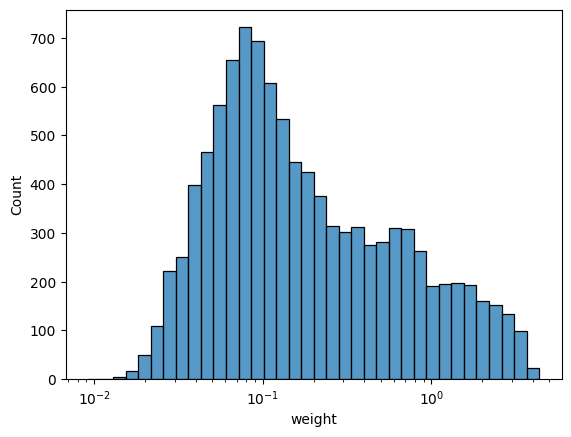

In [24]:
sns.histplot(df[df['target'] > 0]['weight'], kde=False, log_scale=True)

<Axes: xlabel='target', ylabel='Count'>

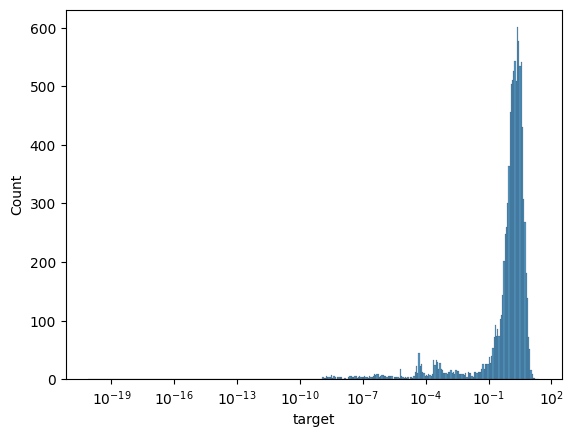

In [25]:
sns.histplot(non_zero_targets, kde=False, log_scale=True)

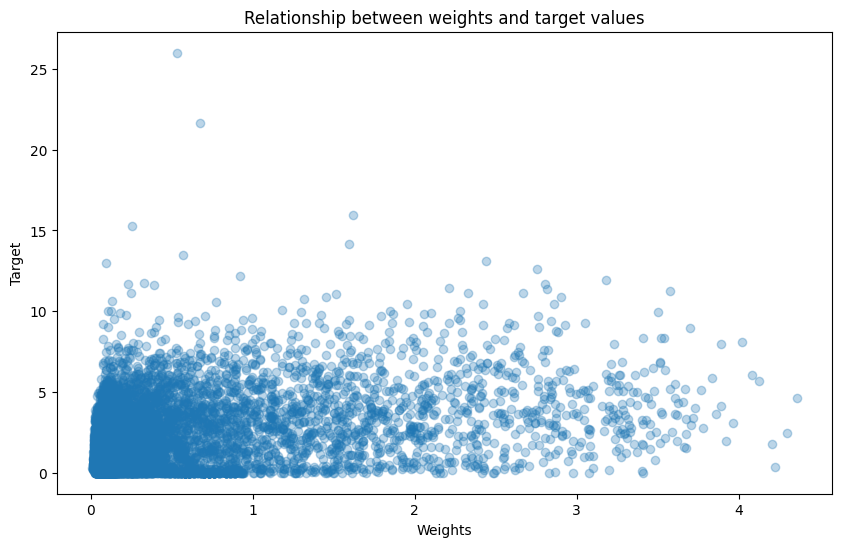

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df[df['target'] > 0]['weight'], non_zero_targets, alpha=0.3)
plt.title('Relationship between weights and target values')
plt.xlabel('Weights')
plt.ylabel('Target')
plt.show()

## Time derived features

In [27]:
# Adding session feature columns for each defined session:
for session_name, session_info in sessions.items():
    feature_name = f'session_{session_name}_feature'
    df[feature_name] = df.apply(lambda row: compute_session_feature(row, session_info), axis=1)
    print(f'Added session time activity for: {feature_name}')

Added session time activity for: session_NYSE_feature
Added session time activity for: session_NASDAQ_feature
Added session time activity for: session_LSE_feature
Added session time activity for: session_Xetra_feature
Added session time activity for: session_TSE_Morning_feature
Added session time activity for: session_TSE_Afternoon_feature
Added session time activity for: session_SSE_Morning_feature
Added session time activity for: session_SSE_Afternoon_feature
Added session time activity for: session_BSE_feature
Added session time activity for: session_ASX_feature
Added session time activity for: session_HOSE_Morning_feature
Added session time activity for: session_HOSE_Afternoon_feature
Added session time activity for: session_PSE_Morning_feature
Added session time activity for: session_PSE_Afternoon_feature
Added session time activity for: session_PSX_feature
Added session time activity for: session_SET_Morning_feature
Added session time activity for: session_SET_Afternoon_feature
A

In [28]:
df["hour"] = df["pairCreatedAt"].dt.hour
df["weekday"] = df["pairCreatedAt"].dt.weekday  # Monday = 0, Sunday = 6

In [29]:
df['session_NYSE_feature'].value_counts()

session_NYSE_feature
 0.992709    29
 0.935016    27
 0.998167    24
 0.987050    24
 0.617036    23
             ..
-0.156385     1
-0.689004     1
-0.585608     1
-0.385732     1
 0.961483     1
Name: count, Length: 73190, dtype: int64

In [30]:
df["current_priceUsd"]

0         0.000000
1         0.000000
2         0.000000
4         0.000000
5         0.000000
            ...   
647409    0.000000
647411    0.000003
647413    0.000142
647415    0.000000
647417    0.000012
Name: current_priceUsd, Length: 419366, dtype: float64

# Worthy calculation for classification

In [31]:
# Define the columns of interest
columns = ['current_volume_h24', 'current_liquidity_usd', 'price_ratio', 'current_txns_sum']

# Calculate the 0.99 quantile for each column
quantiles = {col: df[col].quantile(WORTHY_QUANTILE_THRESHOLD) for col in columns}
quantiles_series = pd.Series(quantiles)
print('Threshold per important feature:')
print(quantiles_series)

# Set 'worthy' to 1 if for each of the selected columns the value is greater than its 0.99 quantile, else 0.
# Use .gt with axis='columns' to align each column's value with its corresponding quantile.
df['worthy'] = df[columns].ge(quantiles_series, axis='columns').all(axis=1).astype(int)

Threshold per important feature:
current_volume_h24         76.601125
current_liquidity_usd    7943.813625
price_ratio                 0.193596
current_txns_sum            6.000000
dtype: float64


In [32]:
df[df['worthy'] > 0].describe()

,dexId,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,...,session_DFM_feature,session_NSE_Nigeria_feature,session_BIST_Morning_feature,session_BIST_Afternoon_feature,session_NSE_Kenya_feature,session_B3_feature,session_BCBA_feature,session_BVC_feature,hour,weekday
count,1148.000000,1.148000e+03,1.148000e+03,1148.00000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,...,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000
mean,5.189895,3.118919e-02,6.263056e+00,191.05662,124.145470,192.369338,124.720383,192.369338,124.720383,192.369338,...,-0.554456,-0.551553,-0.625645,-0.546273,-0.514464,-0.197438,-0.219097,-0.158238,12.877178,2.856272
min,2.000000,7.400000e-15,1.370000e-12,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.999996,-0.999999,-1.000000,-1.000000,-0.999996,-1.000000,-0.999998,-1.000000,0.000000,0.000000
25%,4.000000,3.489250e-07,5.110250e-05,38.00000,14.000000,38.000000,14.000000,38.000000,14.000000,38.000000,...,-0.945466,-0.938533,-0.954813,-0.924655,-0.934757,-0.806095,-0.797964,-0.746598,6.000000,1.000000
50%,6.000000,4.892000e-07,8.562000e-05,109.00000,57.000000,109.000000,57.000000,109.000000,57.000000,109.000000,...,-0.757610,-0.741494,-0.795675,-0.715574,-0.733038,-0.348235,-0.376358,-0.300532,15.000000,3.000000
75%,6.000000,1.272000e-06,2.395250e-04,231.00000,146.000000,231.250000,146.250000,231.250000,146.250000,231.250000,...,-0.321026,-0.361659,-0.415780,-0.344559,-0.270682,0.364074,0.282028,0.491021,19.000000,4.000000
max,6.000000,2.967090e+01,6.282530e+03,3394.00000,2066.000000,4114.000000,2336.000000,4114.000000,2336.000000,4114.000000,...,0.999555,1.000000,0.999736,0.999310,0.999994,1.000000,1.000000,0.999980,23.000000,6.000000
std,1.300728,8.803513e-01,1.858971e+02,270.05919,198.649259,278.485851,201.476830,278.485851,201.476830,278.485851,...,0.513187,0.519235,0.442486,0.500190,0.546364,0.663830,0.654216,0.672837,7.462880,1.932443


<Axes: xlabel='weight', ylabel='Count'>

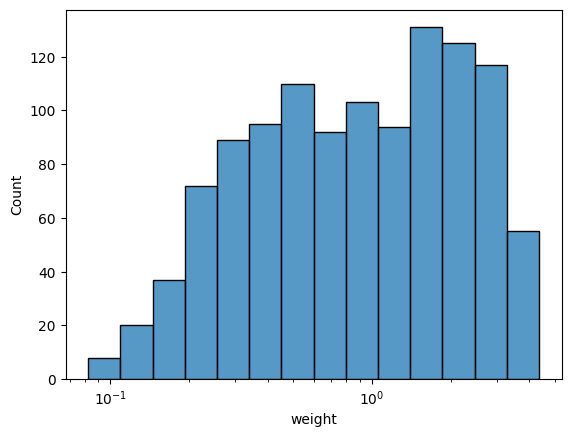

In [33]:
sns.histplot(df[df['worthy'] > 0]['weight'], kde=False, log_scale=True)

<Axes: xlabel='target', ylabel='Count'>

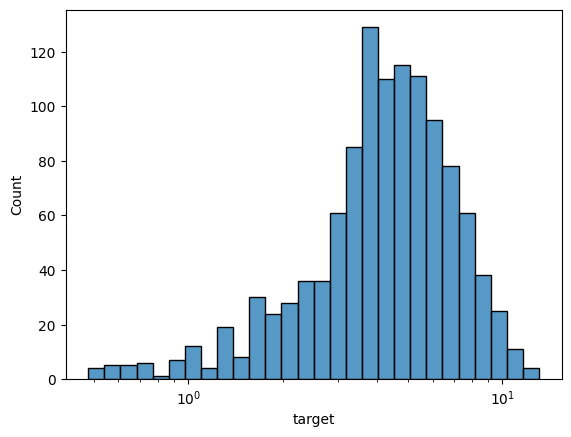

In [34]:
sns.histplot(df[df['worthy'] > 0]['target'], kde=False, log_scale=True)

# Embedding of tokens names and symbols

## Create embeddings

In [35]:
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu126
True


In [36]:
# Wybierz jeden z topowych modeli open-source
# Przykłady:
# model_name = 'nvidia/NV-Embed-v2' # Sprawdź dokładną nazwę na Hugging Face, może wymagać akceptacji licencji
# model_name = 'BAAI/bge-large-en-v1.5'
model_name = 'mixedbread-ai/mxbai-embed-large-v1'
# model_name = 'thenlper/gte-large'
# model_name = 'intfloat/e5-large-v2'
# model_name = 'mixedbread-ai/mxbai-embed-large-v1'
# model_name = 'Salesforce/SFR-Embedding-Mistral' # Inny mocny model, warto sprawdzić aktualne rankingi

In [37]:
if torch.cuda.is_available():
    device = "cuda"
else:
    raise ValueError('CUDA not available!')

# Ładujemy model na odpowiednim urządzeniu
model = SentenceTransformer(model_name, device=device)
print(f"Model loaded on: {device}")

Model loaded on: cuda


In [38]:
# Zakładamy, że 'df' to Twój DataFrame po wstępnym przetworzeniu
token_names = df["baseTokenName"].copy()
token_symbols = df["baseTokenSymbol"].copy()

# token_names = token_names.dropna().str.lower().apply(clean_string).drop_duplicates()
# token_symbols = token_symbols.dropna().str.lower().apply(clean_string).drop_duplicates()
token_names = token_names.astype(str).str.lower().fillna('').tolist()
token_symbols = token_symbols.astype(str).str.lower().fillna('').tolist()

In [39]:
print(f'Names size: {len(token_names)} Symbols size: {len(token_symbols)}')

Names size: 419366 Symbols size: 419366


In [40]:
# --- Generowanie pełnowymiarowych embeddingów ---
print("Generowanie pełnowymiarowych embeddingów dla nazw...")
# Konwertuj od razu do numpy i upewnij się, że jest na CPU do PCA
# full_names_embeddings = model.encode(token_names, show_progress_bar=True, convert_to_numpy=True)
full_names_embeddings = model.encode(
    token_names,
    show_progress_bar=True,
    convert_to_numpy=True,
    device='cuda',
    batch_size=32
)

print("Generowanie pełnowymiarowych embeddingów dla symboli...")
# full_symbols_embeddings = model.encode(token_symbols, show_progress_bar=True, convert_to_numpy=True)
full_symbols_embeddings = model.encode(
    token_symbols,
    show_progress_bar=True,
    convert_to_numpy=True,
    device='cuda',
    batch_size=32
)

print(f"Oryginalna wymiarowość wektorów nazw: {full_names_embeddings.shape[1]}")
print(f"Oryginalna wymiarowość wektorów symboli: {full_symbols_embeddings.shape[1]}")

Generowanie pełnowymiarowych embeddingów dla nazw...


Batches:   0%|          | 0/13106 [00:00<?, ?it/s]

Generowanie pełnowymiarowych embeddingów dla symboli...


Batches:   0%|          | 0/13106 [00:00<?, ?it/s]

Oryginalna wymiarowość wektorów nazw: 1024
Oryginalna wymiarowość wektorów symboli: 1024


## Reduce embeddings dimenions

### XGBoost importances

In [41]:
# Train XGBClassifier with CUDA for symbols ('worthy')
print("Training XGBClassifier for symbols (using 'worthy') with CUDA...")
xgb_symbol_cls = XGBClassifier(device="cuda",
                               seed=RND_STATE,
                               tree_method='hist',
                               verbosity=2)
xgb_symbol_cls.fit(full_symbols_embeddings, df['worthy'])

# Train XGBRegressor with CUDA for symbols ('target' with sample_weight 'weight')
print("Training XGBRegressor for symbols (using 'target' with sample_weight 'weight') with CUDA...")
xgb_symbol_reg = XGBRegressor(device="cuda",
                               seed=RND_STATE,
                               tree_method='hist',
                               verbosity=2)
mask = df['target'] > 0
xgb_symbol_reg.fit(full_symbols_embeddings[mask.values],
    df.loc[mask, 'target'],
    sample_weight=df.loc[mask, 'weight'])

# Obtain feature importances
print("Obtaining feature importances for symbols...")
symbol_cls_importances = xgb_symbol_cls.feature_importances_
symbol_reg_importances = xgb_symbol_reg.feature_importances_

# Select features based on cumulative importance threshold for both models
selected_symbol_indices_cls = select_features_cumulative(symbol_cls_importances, FEATURE_IMPORTANCE_THRESHOLD)
selected_symbol_indices_reg = select_features_cumulative(symbol_reg_importances, FEATURE_IMPORTANCE_THRESHOLD)

# Union selected features from classification and regression models
selected_symbol_indices = np.union1d(selected_symbol_indices_cls, selected_symbol_indices_reg)
print(f"Selected {len(selected_symbol_indices)} combined features for symbols.")

# Save the final list of symbol indices
joblib.dump(selected_symbol_indices, SYMBOL_INDICES_PATH)

# Reduce symbols embeddings matrix using selected indices
reduced_symbols_embeddings = full_symbols_embeddings[:, selected_symbol_indices]
print("Reduced symbols embeddings shape:", reduced_symbols_embeddings.shape)

Training XGBClassifier for symbols (using 'worthy') with CUDA...
Training XGBRegressor for symbols (using 'target' with sample_weight 'weight') with CUDA...
Obtaining feature importances for symbols...
Selected 141 combined features for symbols.
Reduced symbols embeddings shape: (419366, 141)


In [42]:
# Train XGBClassifier with CUDA for names ('worthy')
print("Training XGBClassifier for names (using 'worthy') with CUDA...")
xgb_names_cls = XGBClassifier(device="cuda",
                               seed=RND_STATE,
                               tree_method='hist',
                               verbosity=2)
xgb_names_cls.fit(full_names_embeddings, df['worthy'])

# Train XGBRegressor with CUDA for names ('target' with sample_weight 'weight')
print("Training XGBRegressor for names (using 'target' with sample_weight 'weight') with CUDA...")
xgb_names_reg = XGBRegressor(device="cuda",
                               seed=RND_STATE,
                               tree_method='hist',
                               verbosity=2)
mask = df['target'] > 0
xgb_names_reg.fit(
    full_names_embeddings[mask.values],
    df.loc[mask, 'target'],
    sample_weight=df.loc[mask, 'weight']
)

# Obtain feature importances
print("Obtaining feature importances for names...")
names_cls_importances = xgb_names_cls.feature_importances_
names_reg_importances = xgb_names_reg.feature_importances_

# Select features based on cumulative importance threshold for both models
selected_names_indices_cls = select_features_cumulative(names_cls_importances, FEATURE_IMPORTANCE_THRESHOLD)
selected_names_indices_reg = select_features_cumulative(names_reg_importances, FEATURE_IMPORTANCE_THRESHOLD)

# Union selected features from classification and regression models
selected_names_indices = np.union1d(selected_names_indices_cls, selected_names_indices_reg)
print(f"Selected {len(selected_names_indices)} combined features for names.")

# Save the final list of symbol indices
joblib.dump(selected_names_indices, NAME_INDICES_PATH)

# Reduce symbols embeddings matrix using selected indices
reduced_names_embeddings = full_names_embeddings[:, selected_names_indices]
print("Reduced symbols embeddings shape:", reduced_names_embeddings.shape)

Training XGBClassifier for names (using 'worthy') with CUDA...
Training XGBRegressor for names (using 'target' with sample_weight 'weight') with CUDA...
Obtaining feature importances for names...
Selected 144 combined features for names.
Reduced symbols embeddings shape: (419366, 144)


### PLS

In [43]:
# # --- Konfiguracja ---
# # Docelowa liczba wymiarów (komponentów PLS)
# NAME_COMPONENTS = TOKENIZED_NEME_DIM
# SYMBOL_COMPONENTS = TOKENIZED_SYMBOL_DIM
# # Ścieżka do zapisu modeli redukcji
# MODEL_SAVE_DIR = "models"
# os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
# NAME_REDUCER_PATH = os.path.join(MODEL_SAVE_DIR, "pls_name_reducer.joblib")
# SYMBOL_REDUCER_PATH = os.path.join(MODEL_SAVE_DIR, "pls_symbol_reducer.joblib")

# # Zmienna celu dla nadzorowanej redukcji
# # Używamy 'worthy' dla obu reduktorów, aby zoptymalizować pod kątem klasyfikacji
# y_target = df['worthy']

# # --- Redukcja wymiarowości dla Nazw ---
# print(f"Trenowanie reduktora PLS dla nazw (target: worthy, komponenty: {NAME_COMPONENTS})...")
# pls_name_reducer = PLSRegression(n_components=NAME_COMPONENTS, scale=False) # scale=False, zakładając normalizację przez SentenceTransformer
# pls_name_reducer.fit(full_names_embeddings, y_target)

# print("Transformacja embeddingów nazw...")
# reduced_names_embeddings = pls_name_reducer.transform(full_names_embeddings)

# print(f"Zapisywanie modelu reduktora nazw do: {NAME_REDUCER_PATH}")
# joblib.dump(pls_name_reducer, NAME_REDUCER_PATH)

# # --- Redukcja wymiarowości dla Symboli ---
# print(f"Trenowanie reduktora PLS dla symboli (target: worthy, komponenty: {SYMBOL_COMPONENTS})...")
# pls_symbol_reducer = PLSRegression(n_components=SYMBOL_COMPONENTS, scale=False) # scale=False
# pls_symbol_reducer.fit(full_symbols_embeddings, y_target)

# print("Transformacja embeddingów symboli...")
# reduced_symbols_embeddings = pls_symbol_reducer.transform(full_symbols_embeddings)

# print(f"Zapisywanie modelu reduktora symboli do: {SYMBOL_REDUCER_PATH}")
# joblib.dump(pls_symbol_reducer, SYMBOL_REDUCER_PATH)

# # --- Weryfikacja i Przygotowanie danych do dalszego przetwarzania ---
# print(f"Nowa wymiarowość wektorów nazw: {reduced_names_embeddings.shape}")
# print(f"Nowa wymiarowość wektorów symboli: {reduced_symbols_embeddings.shape}")

# # Utworzenie DataFrame z nowymi, zredukowanymi wektorami
# names_vectors_df = pd.DataFrame(
#     reduced_names_embeddings,
#     index=df.index,
#     columns=[f"nameVectorPLS_Dim{i}" for i in range(NAME_COMPONENTS)]
# )
# symbols_vectors_df = pd.DataFrame(
#     reduced_symbols_embeddings,
#     index=df.index,
#     columns=[f"symbolVectorPLS_Dim{i}" for i in range(SYMBOL_COMPONENTS)]
# )

# # Opcjonalnie: Usuń stare kolumny embeddingów (jeśli były dodane wcześniej)
# # df = df.drop(columns=[col for col in df.columns if 'nameVectorDim' in col or 'symbolVectorDim' in col], errors='ignore')

# # Łączenie zredukowanych wektorów z oryginalnym DataFrame
# df_reduced = pd.concat([df, names_vectors_df, symbols_vectors_df], axis=1)

# print("Zakończono redukcję wymiarowości metodą PLS i dodano nowe cechy do DataFrame.")

# # --- Przykład użycia zapisanych modeli w procesie predykcji ---
# # W scenariuszu predykcji dla nowych danych:
# # 1. Wygeneruj pełnowymiarowe embeddingi dla nowych nazw/symboli (np. new_name_embeddings, new_symbol_embeddings)
# # 2. Wczytaj zapisane modele:
# #    loaded_name_reducer = joblib.load(NAME_REDUCER_PATH)
# #    loaded_symbol_reducer = joblib.load(SYMBOL_REDUCER_PATH)
# # 3. Przetransformuj nowe embeddingi:
# #    new_reduced_names = loaded_name_reducer.transform(new_name_embeddings)
# #    new_reduced_symbols = loaded_symbol_reducer.transform(new_symbol_embeddings)
# # 4. Użyj new_reduced_names i new_reduced_symbols jako wejścia do modeli klasyfikacji/regresji.


### RandomForest importances

#### v1

In [44]:
# # Założenia:
# # - Istnieją zmienne:
# #   - full_names_embeddings: np.array z pełnowymiarowymi embeddingami nazw
# #   - full_symbols_embeddings: np.array z pełnowymiarowymi embeddingami symboli
# #   - df: pandas DataFrame zawierający kolumnę 'worthy'
# # - Zdefiniowano stałe:
# #   - TOKENIZED_NEME_DIM = 128 # Teraz interpretowane jako LICZBA najważniejszych wymiarów do wybrania
# #   - TOKENIZED_SYMBOL_DIM = 64  # Teraz interpretowane jako LICZBA najważniejszych wymiarów do wybrania

# # --- Konfiguracja ---
# # Liczba najważniejszych wymiarów do zachowania
# NUM_NAME_FEATURES_TO_SELECT = TOKENIZED_NEME_DIM
# NUM_SYMBOL_FEATURES_TO_SELECT = TOKENIZED_SYMBOL_DIM

# # Ścieżka do zapisu list indeksów
# SELECTION_SAVE_DIR = "models"
# os.makedirs(SELECTION_SAVE_DIR, exist_ok=True)
# NAME_INDICES_PATH = os.path.join(SELECTION_SAVE_DIR, "important_name_indices.joblib")
# SYMBOL_INDICES_PATH = os.path.join(SELECTION_SAVE_DIR, "important_symbol_indices.joblib")

# # Zmienna celu dla nadzorowanej selekcji
# y_target = df['worthy']

# # Sprawdzenie wymiarów wejściowych
# original_name_dim = full_names_embeddings.shape[1]
# original_symbol_dim = full_symbols_embeddings.shape[1]

# if NUM_NAME_FEATURES_TO_SELECT > original_name_dim:
#     print(f"Ostrzeżenie: Żądana liczba wymiarów nazw ({NUM_NAME_FEATURES_TO_SELECT}) jest większa niż oryginalna ({original_name_dim}). Wybieram wszystkie.")
#     NUM_NAME_FEATURES_TO_SELECT = original_name_dim

# if NUM_SYMBOL_FEATURES_TO_SELECT > original_symbol_dim:
#     print(f"Ostrzeżenie: Żądana liczba wymiarów symboli ({NUM_SYMBOL_FEATURES_TO_SELECT}) jest większa niż oryginalna ({original_symbol_dim}). Wybieram wszystkie.")
#     NUM_SYMBOL_FEATURES_TO_SELECT = original_symbol_dim


# # --- Selekcja wymiarów dla Nazw ---
# print(f"Trenowanie RandomForestClassifier do oceny ważności wymiarów nazw (target: worthy)...")
# # Używamy lekkiego modelu, bo interesuje nas tylko ranking ważności
# rf_name_selector = RandomForestClassifier(n_jobs=-1)
# rf_name_selector.fit(full_names_embeddings, y_target)

# print("Pobieranie i sortowanie ważności wymiarów nazw...")
# name_importances = rf_name_selector.feature_importances_
# # Sortowanie indeksów od najważniejszego do najmniej ważnego
# sorted_name_indices = np.argsort(name_importances)[::-1]
# # Wybór N najważniejszych indeksów
# selected_name_indices = sorted_name_indices[:NUM_NAME_FEATURES_TO_SELECT]
# # Sortowanie wybranych indeksów, aby zachować pewien porządek (opcjonalne, ale ułatwia porównania)
# selected_name_indices = np.sort(selected_name_indices)

# print(f"Wybrano {len(selected_name_indices)} najważniejszych wymiarów nazw.")
# print(f"Zapisywanie listy indeksów nazw do: {NAME_INDICES_PATH}")
# joblib.dump(selected_name_indices, NAME_INDICES_PATH)

# print("Redukcja embeddingów nazw przez selekcję wymiarów...")
# reduced_names_embeddings = full_names_embeddings[:, selected_name_indices]

# # --- Selekcja wymiarów dla Symboli ---
# print(f"Trenowanie RandomForestClassifier do oceny ważności wymiarów symboli (target: worthy)...")
# rf_symbol_selector = RandomForestClassifier(n_jobs=-1)
# rf_symbol_selector.fit(full_symbols_embeddings, y_target)

# print("Pobieranie i sortowanie ważności wymiarów symboli...")
# symbol_importances = rf_symbol_selector.feature_importances_
# sorted_symbol_indices = np.argsort(symbol_importances)[::-1]
# selected_symbol_indices = sorted_symbol_indices[:NUM_SYMBOL_FEATURES_TO_SELECT]
# selected_symbol_indices = np.sort(selected_symbol_indices) # Sortowanie dla spójności

# print(f"Wybrano {len(selected_symbol_indices)} najważniejszych wymiarów symboli.")
# print(f"Zapisywanie listy indeksów symboli do: {SYMBOL_INDICES_PATH}")
# joblib.dump(selected_symbol_indices, SYMBOL_INDICES_PATH)

# print("Redukcja embeddingów symboli przez selekcję wymiarów...")
# reduced_symbols_embeddings = full_symbols_embeddings[:, selected_symbol_indices]

# # --- Weryfikacja i Przygotowanie danych do dalszego przetwarzania ---
# print(f"Nowa wymiarowość wektorów nazw: {reduced_names_embeddings.shape}")
# print(f"Nowa wymiarowość wektorów symboli: {reduced_symbols_embeddings.shape}")

# # --- Przykład użycia zapisanych list indeksów w procesie predykcji ---
# # W scenariuszu predykcji dla nowych danych:
# # 1. Wygeneruj pełnowymiarowe embeddingi dla nowych nazw/symboli (np. new_name_embeddings, new_symbol_embeddings)
# # 2. Wczytaj zapisane listy indeksów:
# #    loaded_name_indices = joblib.load(NAME_INDICES_PATH)
# #    loaded_symbol_indices = joblib.load(SYMBOL_INDICES_PATH)
# # 3. Wybierz odpowiednie wymiary (slicing):
# #    new_reduced_names = new_name_embeddings[:, loaded_name_indices]
# #    new_reduced_symbols = new_symbol_embeddings[:, loaded_symbol_indices]
# # 4. Użyj new_reduced_names i new_reduced_symbols jako wejścia do modeli klasyfikacji/regresji.

#### v2

In [45]:
# if REFIT_REDUCE_MODELS:
#     # --- FEATURE SELECTION FOR SYMBOLS EMBEDDINGS ---
#     # Classification model uses only 'worthy'
#     print("Training RandomForestClassifier for symbols (using 'worthy')...")
#     rf_symbol_cls = RandomForestClassifier(n_jobs=-1)
#     rf_symbol_cls.fit(full_symbols_embeddings, df['worthy'])
    
#     # Regression model uses both 'target' (as dependent variable) and 'weight' (as sample weights)
#     print("Training RandomForestRegressor for symbols (using 'target' with sample_weight 'weight')...")
#     rf_symbol_reg = RandomForestRegressor(n_jobs=-1)
#     rf_symbol_reg.fit(full_symbols_embeddings, df['target'], sample_weight=df['weight'])

In [46]:
# print("Obtaining feature importances for symbols...")
# symbol_cls_importances = rf_symbol_cls.feature_importances_
# symbol_reg_importances = rf_symbol_reg.feature_importances_

# # Select features based on cumulative importance threshold for both models
# selected_symbol_indices_cls = select_features_cumulative(symbol_cls_importances, FEATURE_IMPORTANCE_THRESHOLD)
# selected_symbol_indices_reg = select_features_cumulative(symbol_reg_importances, FEATURE_IMPORTANCE_THRESHOLD)

# # Compute the intersection (common features) between classification and regression importance selections
# # selected_symbol_indices = np.intersect1d(selected_symbol_indices_cls, selected_symbol_indices_reg)
# selected_symbol_indices = np.union1d(selected_symbol_indices_cls, selected_symbol_indices_reg)
# print(f"Selected {len(selected_symbol_indices)} common features for symbols.")

# # Save the final list of symbol indices
# joblib.dump(selected_symbol_indices, SYMBOL_INDICES_PATH)

# # Reduce the symbols embeddings matrix using the selected indices
# reduced_symbols_embeddings = full_symbols_embeddings[:, selected_symbol_indices]
# print("Reduced symbols embeddings shape:", reduced_symbols_embeddings.shape)

In [47]:
# if REFIT_REDUCE_MODELS:
#     # --- FEATURE SELECTION FOR NAMES EMBEDDINGS ---
#     # Classification model uses only 'worthy'
#     print("Training RandomForestClassifier for names (using 'worthy')...")
#     rf_name_cls = RandomForestClassifier(n_jobs=-1)
#     rf_name_cls.fit(full_names_embeddings, df['worthy'])
    
#     # Regression model uses both 'target' (as dependent variable) and 'weight' (as sample weights)
#     print("Training RandomForestRegressor for names (using 'target' with sample_weight 'weight')...")
#     rf_name_reg = RandomForestRegressor(n_jobs=-1)
#     rf_name_reg.fit(full_names_embeddings, df['target'], sample_weight=df['weight'])

In [48]:
# print("Obtaining feature importances for names...")
# name_cls_importances = rf_name_cls.feature_importances_
# name_reg_importances = rf_name_reg.feature_importances_

# # Select features based on cumulative importance threshold for both models
# selected_name_indices_cls = select_features_cumulative(name_cls_importances, FEATURE_IMPORTANCE_THRESHOLD)
# selected_name_indices_reg = select_features_cumulative(name_reg_importances, FEATURE_IMPORTANCE_THRESHOLD)

# # Compute the intersection (common features) between classification and regression importance selections
# # selected_name_indices = np.intersect1d(selected_name_indices_cls, selected_name_indices_reg)
# selected_name_indices = np.union1d(selected_name_indices_cls, selected_name_indices_reg)
# print(f"Selected {len(selected_name_indices)} common features for names.")

# # Save the final list of name indices
# joblib.dump(selected_name_indices, NAME_INDICES_PATH)

# # Reduce the names embeddings matrix using the selected indices
# reduced_names_embeddings = full_names_embeddings[:, selected_name_indices]
# print("Reduced names embeddings shape:", reduced_names_embeddings.shape)

In [49]:
# --- USAGE EXAMPLE DURING PREDICTION ---
# For prediction on new data:
#   1. Generate full-dimension embeddings for new names and symbols (e.g., new_name_embeddings, new_symbol_embeddings)
#   2. Load the saved indices:
#         loaded_name_indices = joblib.load(NAME_INDICES_PATH)
#         loaded_symbol_indices = joblib.load(SYMBOL_INDICES_PATH)
#   3. Slice the new embeddings to reduce dimensions:
#         new_reduced_names = new_name_embeddings[:, loaded_name_indices]
#         new_reduced_symbols = new_symbol_embeddings[:, loaded_symbol_indices]
#   4. Use new_reduced_names and new_reduced_symbols as input features for the four trained models.

In [50]:
# # -------------------------- Wizualizacja ważności cech --------------------------

# # Dla embeddingów nazw: uporządkuj wybrane indeksy wg malejącej wartości ważności
# selected_name_indices_desc = np.array(selected_name_indices)[np.argsort(name_importances[selected_name_indices])[::-1]]
# selected_name_importances = name_importances[selected_name_indices_desc]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(selected_name_importances)), 
#         selected_name_importances, 
#         tick_label=[f"Dim {i}" for i in selected_name_indices_desc])
# plt.xlabel("Indeks wymiaru (Names)")
# plt.ylabel("Ważność cechy")
# plt.title("Ważność cech dla embeddingów nazw")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

# # Dla embeddingów symboli: uporządkuj wybrane indeksy wg malejącej wartości ważności
# selected_symbol_indices_desc = np.array(selected_symbol_indices)[np.argsort(symbol_importances[selected_symbol_indices])[::-1]]
# selected_symbol_importances = symbol_importances[selected_symbol_indices_desc]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(selected_symbol_importances)), 
#         selected_symbol_importances, 
#         tick_label=[f"Dim {i}" for i in selected_symbol_indices_desc])
# plt.xlabel("Indeks wymiaru (Symbols)")
# plt.ylabel("Ważność cechy")
# plt.title("Ważność cech dla embeddingów symboli")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

# # -------------------------- Wizualizacja redukcji wymiarowości (PCA) --------------------------

# # PCA dla zredukowanych embeddingów nazw
# pca_names = PCA(n_components=2)
# reduced_names_2d = pca_names.fit_transform(reduced_names_embeddings)

# plt.figure(figsize=(8, 6))
# plt.scatter(reduced_names_2d[:, 0], 
#             reduced_names_2d[:, 1], 
#             c=y_target,         # kolorowanie według zmiennej celu 'worthy'
#             cmap='viridis', 
#             alpha=0.7)
# plt.xlabel("Komponent główny 1")
# plt.ylabel("Komponent główny 2")
# plt.title("Wizualizacja PCA dla wybranych embeddingów nazw")
# plt.colorbar(label="Target (worthy)")
# plt.tight_layout()
# plt.show()

# # PCA dla zredukowanych embeddingów symboli
# pca_symbols = PCA(n_components=2)
# reduced_symbols_2d = pca_symbols.fit_transform(reduced_symbols_embeddings)

# plt.figure(figsize=(8, 6))
# plt.scatter(reduced_symbols_2d[:, 0], 
#             reduced_symbols_2d[:, 1], 
#             c=y_target, 
#             cmap='viridis', 
#             alpha=0.7)
# plt.xlabel("Komponent główny 1")
# plt.ylabel("Komponent główny 2")
# plt.title("Wizualizacja PCA dla wybranych embeddingów symboli")
# plt.colorbar(label="Target (worthy)")
# plt.tight_layout()
# plt.show()

### Simple slicing

In [51]:
# print(f"Redukowanie wymiarowości nazw do {TOKENIZED_NEME_DIM} przez obcięcie...")
# # Slicing NumPy: bierzemy wszystkie wiersze (:) i pierwsze TOKENIZED_NEME_DIM kolumn
# reduced_names_embeddings = full_names_embeddings[:, :TOKENIZED_NEME_DIM]
# print(f"Nowa wymiarowość wektorów nazw: {reduced_names_embeddings.shape[1]}")

# print(f"Redukowanie wymiarowości symboli do {TOKENIZED_SYMBOL_DIM} przez obcięcie...")
# # Slicing NumPy: bierzemy wszystkie wiersze (:) i pierwsze TOKENIZED_SYMBOL_DIM kolumn
# reduced_symbols_embeddings = full_symbols_embeddings[:, :TOKENIZED_SYMBOL_DIM]
# print(f"Nowa wymiarowość wektorów symboli: {reduced_symbols_embeddings.shape[1]}")

# names_vectors_df = pd.DataFrame(reduced_names_embeddings, index=df.index, columns=[f"nameVectorDim{i}" for i in range(TOKENIZED_NEME_DIM)])
# symbols_vectors_df = pd.DataFrame(reduced_symbols_embeddings, index=df.index, columns=[f"symbolVectorDim{i}" for i in range(TOKENIZED_SYMBOL_DIM)])

# # Łączenie z oryginalnym DataFrame
# df = pd.concat([df, names_vectors_df, symbols_vectors_df], axis=1)

## Older

In [52]:
# # Create an explicit copy of the selected columns
# names_symbols = df[["baseTokenName", "baseTokenSymbol"]].copy()

# # Remove duplicates based on baseTokenName and baseTokenSymbol
# names_symbols = names_symbols.drop_duplicates(subset=["baseTokenName"])
# names_symbols = names_symbols.drop_duplicates(subset=["baseTokenSymbol"])

# # Convert text to lowercase using .loc for assignment
# names_symbols.loc[:, "baseTokenName"] = names_symbols["baseTokenName"].str.lower()
# names_symbols.loc[:, "baseTokenSymbol"] = names_symbols["baseTokenSymbol"].str.lower()

# # Filter rows based on the length of 'baseTokenName'
# names_symbols = names_symbols[
#     names_symbols["baseTokenName"].str.len() <= TOKEN_NAME_MAX_LEN
# ]

# # Filter rows based on the length of 'baseTokenSymbol'
# names_symbols = names_symbols[
#     names_symbols["baseTokenSymbol"].str.len() <= TOKEN_SYMBOL_MAX_LEN
# ]

# # Reset index
# names_symbols.reset_index(drop=True, inplace=True)

# # Display the DataFrame
# names_symbols

In [53]:



# if CLEAN_TOKEN_NAMES_STR:
#     names_symbols["baseTokenName"] = names_symbols["baseTokenName"].apply(clean_string)
#     names_symbols["baseTokenSymbol"] = names_symbols["baseTokenSymbol"].apply(
#         clean_string
#     )

In [54]:
# with open("data/baseTokenNames.txt", "w", encoding="utf-8") as f:
#     for entry in names_symbols[
#         "baseTokenName"
#     ]:  # Zmień na nazwę kolumny, którą chcesz użyć
#         f.write(str(entry) + "\n")  # Zapewniamy, że każda wartość jest stringiem

# with open("data/baseTokenSymbols.txt", "w", encoding="utf-8") as f:
#     for entry in names_symbols[
#         "baseTokenSymbol"
#     ]:  # Zmień na nazwę kolumny, którą chcesz użyć
#         f.write(str(entry) + "\n")  # Zapewniamy, że każda wartość jest stringiem

In [55]:
# # names model
# model_n = fasttext.train_unsupervised(
#     "data/baseTokenNames.txt", model="skipgram", dim=TOKENIZED_NEME_DIM, minCount=1, minn=2, verbose=1
# )
# model_n.save_model("models/names2vec_model.bin")

# # symbols model
# model_s = fasttext.train_unsupervised(
#     "data/baseTokenSymbols.txt", model="skipgram", dim=TOKENIZED_SYMBOL_DIM, minCount=1, minn=1, verbose=1
# )
# model_s.save_model("models/symbols2vec_model.bin")

In [56]:
# names_vectors = (
#     df["baseTokenName"]
#     .astype(str)
#     .apply(lambda x: pd.Series(model_n.get_word_vector(x)))
# )
# names_vectors.columns = [f"nameVectorDim{i}" for i in range(TOKENIZED_NEME_DIM)]
# names_vectors

In [57]:
# symbols_vectors = (
#     df["baseTokenSymbol"]
#     .astype(str)
#     .apply(lambda x: pd.Series(model_s.get_word_vector(x)))
# )
# symbols_vectors.columns = [f"symbolVectorDim{i}" for i in range(TOKENIZED_SYMBOL_DIM)]
# symbols_vectors

In [58]:
# df = pd.concat([df, names_vectors, symbols_vectors], axis=1)
# df

In [59]:
# Utworzenie DataFrame z nowymi, zredukowanymi wektorami
names_vectors_df = pd.DataFrame(
    reduced_names_embeddings,
    index=df.index,
    columns=[f"nameVectorSelected_DimIdx{i}" for i in selected_names_indices] # Używamy oryginalnych indeksów w nazwach dla jasności
)
symbols_vectors_df = pd.DataFrame(
    reduced_symbols_embeddings,
    index=df.index,
    columns=[f"symbolVectorSelected_DimIdx{i}" for i in selected_symbol_indices] # Używamy oryginalnych indeksów w nazwach
)

# Opcjonalnie: Usuń stare kolumny embeddingów
# df = df.drop(columns=[col for col in df.columns if 'nameVectorDim' in col or 'symbolVectorDim' in col], errors='ignore')

# Łączenie zredukowanych wektorów z oryginalnym DataFrame
df = pd.concat([df, names_vectors_df, symbols_vectors_df], axis=1)

print("Zakończono selekcję wymiarów i dodano nowe cechy do DataFrame.")

Zakończono selekcję wymiarów i dodano nowe cechy do DataFrame.


# Finalize features

In [60]:
# df['pairCreatedAt'] = pd.to_datetime(df['pairCreatedAt'])
df = df.sort_values('pairCreatedAt')
df = df.set_index('pairCreatedAt')

# Create the 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Generate and save plots for each column against the datetime index
for column in df.columns:
    # Convert column values to numeric; non-numeric values become NaN
    y = pd.to_numeric(df[column], errors='coerce')
    
    plt.figure()
    plt.plot(df.index, y)
    plt.xlabel('pairCreatedAt')
    plt.ylabel(column)
    plt.title(f'{column} over Time')
    plt.savefig(f'plots/{column}_plot.png')
    plt.close()

# Return df to its original state by resetting the index
df = df.reset_index()

In [61]:
to_drop = [
    "BTCUSDT_ATR_1h",
    "SOLUSDT_ATR_1h",
    "BTCUSDT_ATR_4h",
    "SOLUSDT_ATR_4h",
    "BTCUSDT_RSI_1d",
    "SOLUSDT_RSI_1d",
    "BTCUSDT_ADOSC_1d",
    "SOLUSDT_ADOSC_1d",
    "BTCUSDT_OBV_1d",
    "BTCUSDT_OBV_4h",
    "BTCUSDT_OBV_1h",
    "SOLUSDT_OBV_1d",
    "SOLUSDT_OBV_4h",
    "SOLUSDT_OBV_1h",
    "SOLUSDT_ATR_1d",
    "BTCUSDT_ATR_1d",
    "BTCUSDT_TSF_1d",
    "SOLUSDT_TSF_1d",
    "BTCUSDT_TSF_4h",
    "SOLUSDT_TSF_4h",
    "BTCUSDT_TSF_1h",
    "SOLUSDT_TSF_1h",
    "BTCUSDT_TSF_15m",
    "SOLUSDT_TSF_15m",
    "BTCUSDT_TSF_5m",
    "SOLUSDT_TSF_5m",
    "BTCUSDT_TSF_1m",
    "SOLUSDT_TSF_1m",
    "chainId",
    "url",
    "pairAddress",
    "baseTokenAddress",
    "baseTokenName",
    "baseTokenSymbol",
    "quoteTokenAddress",
    "quoteTokenName",
    "quoteTokenSymbol",
    "pairCreatedAt",
    "current_priceUsd","current_txns_h24_buy","current_txns_h24_sells","current_volume_h24","current_liquidity_usd","price_ratio","current_txns_sum","days_since_listing"
]
df.drop(columns=to_drop, inplace=True)
print(f"Any NaNs in all columns: {df.isna().any().any()}")
print(f"Columns with NaNs: {df.columns[df.isna().any()]}")
print(f"Rows with NaNs {df[df.isna().any(axis=1)]}")

Any NaNs in all columns: False
Columns with NaNs: Index([], dtype='object')
Rows with NaNs Empty DataFrame
Columns: [dexId, priceNative, priceUsd, txns_m5_buys, txns_m5_sells, txns_h1_buys, txns_h1_sells, txns_h6_buys, txns_h6_sells, txns_h24_buy, txns_h24_sells, volume_h24, volume_h6, volume_h1, volume_m5, priceChange_m5, priceChange_h1, priceChange_h6, priceChange_h24, liquidity_usd, liquidity_base, liquidity_quote, fdv, SOLUSDT_ADOSC_1m, SOLUSDT_OBV_1m, SOLUSDT_ATR_1m, SOLUSDT_RSI_1m, SOLUSDT_ULTOSC_1m, SOLUSDT_ADOSC_5m, SOLUSDT_OBV_5m, SOLUSDT_ATR_5m, SOLUSDT_RSI_5m, SOLUSDT_ULTOSC_5m, SOLUSDT_ADOSC_15m, SOLUSDT_OBV_15m, SOLUSDT_ATR_15m, SOLUSDT_RSI_15m, SOLUSDT_ULTOSC_15m, SOLUSDT_ADOSC_1h, SOLUSDT_RSI_1h, SOLUSDT_ULTOSC_1h, SOLUSDT_ADOSC_4h, SOLUSDT_RSI_4h, SOLUSDT_ULTOSC_4h, SOLUSDT_ULTOSC_1d, BTCUSDT_ADOSC_1m, BTCUSDT_OBV_1m, BTCUSDT_ATR_1m, BTCUSDT_RSI_1m, BTCUSDT_ULTOSC_1m, BTCUSDT_ADOSC_5m, BTCUSDT_OBV_5m, BTCUSDT_ATR_5m, BTCUSDT_RSI_5m, BTCUSDT_ULTOSC_5m, BTCUSDT_ADOSC_15m,

In [62]:
# to_drop = [
#     "BTCUSDT_RSI_1d",
#     "SOLUSDT_RSI_1d"
# ]
# df.drop(columns=to_drop, inplace=True)
# print(f"Any NaNs in all columns: {df.isna().any().any()}")
# print(f"Columns with NaNs: {df.columns[df.isna().any()]}")
# print(f"Rows with NaNs {df[df.isna().any(axis=1)]}")

# Transformation and saving

## Classification dataset

In [63]:
# Assume SCALE_DATASETS is defined somewhere as a boolean
if SCALE_DATASET:
    # Reset index on the DataFrame
    df = df.reset_index(drop=True)

    # Remove 'target' and 'weight' columns from the columns to be scaled
    columns_to_exclude = ["target", "weight"]
    df_modeling = df.drop(columns=columns_to_exclude, errors="ignore")

    # Create scaler objects for standard and min-max scaling
    std_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the DataFrame (only selected columns) with the scalers
    std_modeling_array = std_scaler.fit_transform(df_modeling)
    minmax_modeling_array = minmax_scaler.fit_transform(df_modeling)

    # Create DataFrames from the scaled arrays, using the original column names
    std_modeling = pd.DataFrame(std_modeling_array, columns=df_modeling.columns)
    minmax_modeling = pd.DataFrame(minmax_modeling_array, columns=df_modeling.columns)

    # Add back the 'worthy' column to both scaled DataFrames
    std_modeling["worthy"] = df["worthy"].values
    minmax_modeling["worthy"] = df["worthy"].values

    # Reorder columns in alphabetical order for consistency
    std_modeling = std_modeling.reindex(sorted(std_modeling.columns), axis=1)
    minmax_modeling = minmax_modeling.reindex(sorted(minmax_modeling.columns), axis=1)
    df = df.reindex(sorted(df.columns), axis=1)

    # Save scaler models to disk using joblib
    joblib.dump(std_scaler, "models/std_scaler_cls.pkl")
    joblib.dump(minmax_scaler, "models/minmax_scaler_cls.pkl")

    # Save original as well as scaled DataFrames to CSV files
    df.to_csv("data/cls_default_modeling.csv", index=False)
    std_modeling.to_csv("data/cls_std_modeling.csv", index=False)
    minmax_modeling.to_csv("data/cls_minmax_modeling.csv", index=False)
else:
    # Jeśli skalowanie jest wyłączone, zapisujemy tylko oryginalny DataFrame
    df = df.reset_index(drop=True)
    df = df.reindex(sorted(df.columns), axis=1)
    df.to_csv("data/cls_default_modeling.csv", index=False)

## Regression dataset

In [64]:
# Filtering rows where 'target' > 0 and dropping the 'worthy' column
df_filtered = df[df["target"] > 0].copy()
df_filtered = df_filtered.drop(columns=["worthy"], errors="ignore")

if SCALE_DATASET:
    # Create scaler objects for filtered data
    std_scaler_filtered = StandardScaler()
    minmax_scaler_filtered = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the filtered DataFrame with the scalers
    std_filtered_array = std_scaler_filtered.fit_transform(df_filtered)
    minmax_filtered_array = minmax_scaler_filtered.fit_transform(df_filtered)

    # Create DataFrames from scaled arrays using the same columns as df_filtered
    std_filtered = pd.DataFrame(std_filtered_array, columns=df_filtered.columns)
    minmax_filtered = pd.DataFrame(minmax_filtered_array, columns=df_filtered.columns)

    # Reorder columns in alphabetical order for consistency
    std_filtered = std_filtered.reindex(sorted(std_filtered.columns), axis=1)
    minmax_filtered = minmax_filtered.reindex(sorted(minmax_filtered.columns), axis=1)
    df_filtered = df_filtered.reindex(sorted(df_filtered.columns), axis=1)

    # Save scaler models for filtered data
    joblib.dump(std_scaler_filtered, "models/std_scaler_reg.pkl")
    joblib.dump(minmax_scaler_filtered, "models/minmax_scaler_reg.pkl")

    # Save the default and scaled DataFrames to CSV files
    df_filtered.to_csv("data/reg_default_modeling.csv", index=False)
    std_filtered.to_csv("data/reg_std_modeling.csv", index=False)
    minmax_filtered.to_csv("data/reg_minmax_modeling.csv", index=False)
else:
    # Without scaling: Reorder columns and save only the filtered DataFrame
    df_filtered = df_filtered.reindex(sorted(df_filtered.columns), axis=1)
    df_filtered.to_csv("data/reg_default_modeling.csv", index=False)

# PCA

## 2D

In [65]:
# if DISPLAY_PCA:
#     X_pca = PCA(n_components=2).fit_transform(df.drop(columns=["target", "weight"], errors="ignore").drop(columns="worthy"))
    
#     clustered_data = pd.DataFrame(
#         {"PCA1": X_pca[:, 0], "PCA2": X_pca[:, 1], "worthy": df.drop(columns=["target", "weight"], errors="ignore")["worthy"]}
#     )
    
#     plt.figure(figsize=(10, 8))
#     sns.scatterplot(
#         data=clustered_data,
#         x="PCA1",
#         y="PCA2",
#         hue="worthy",
#         palette="viridis",
#         s=100,
#         alpha=0.6,
#     )
#     plt.title("Visualization of Clusters using PCA")
#     plt.xlabel("Principal Component 1")
#     plt.ylabel("Principal Component 2")
#     plt.legend(title="worthy")
#     plt.grid(True)
#     plt.show()

## 3D

In [66]:
# if DISPLAY_PCA:
#     X_pca = PCA(n_components=3).fit_transform(df_modeling.drop(columns="worthy"))
    
#     clustered_data = pd.DataFrame(
#         {
#             "PCA1": X_pca[:, 0],
#             "PCA2": X_pca[:, 1],
#             "PCA3": X_pca[:, 2],
#             "worthy": df_modeling["worthy"],
#         }
#     )
    
#     fig = px.scatter_3d(
#         clustered_data,
#         x="PCA1",
#         y="PCA2",
#         z="PCA3",
#         color="worthy",
#         color_continuous_scale="viridis",
#     )
#     fig.update_layout(
#         title="3D Visualization of Clusters using PCA", margin=dict(l=0, r=0, b=0, t=30)
#     )
#     fig.show()